In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Ionospere dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

## Cuda

In [3]:
torch.cuda.is_available()

False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## utils functions

In [5]:
print(fn_plot_torch_hist.__doc__)

None


In [6]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


## basic parameters

In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'
modelDir = './models'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

EPOCHS = 500 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 16

WEIGHT_DECAY = 0.001

PATIENCE = 30
LR_FACTOR = 0.1
LR_PATIENCE = 10

TRAIN_SIZE = int(17*BATCH_SIZE)


# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.brg
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read Ionosphere data set

In [8]:
filepath = os.path.join(inpDir,'ionosphere', 'ionosphere.data')

data_df = pd.read_csv(filepath, header = None)

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [9]:
train_df, test_df = train_test_split(data_df,
                                     train_size = TRAIN_SIZE, 
                                     stratify = data_df[data_df.columns[-1]],
                                     random_state = RANDOM_STATE)

train_df.shape, test_df.shape

((272, 35), (79, 35))

In [10]:
''' Using Singleton design pattern'''

class Transformers():
    
    '''
    Args:
        has one standard scaler and one label encoder
    '''
    _instance = None
    
    def __init__ (self):
        if Transformers._instance is not None:
            raise Exception ("GlobalScaler  class is a singleton.")
            
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
    
    @ classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance            

##  Scalling and Features and labels extraction to tensor format 

In [11]:
class IonoDS(Dataset):

    transformers = Transformers.get_instance() ## standard scaler and label encoder
    
    def __init__(self, 
                 dataframe : pd.DataFrame,
                 device: str = device,
                is_train = True,
                label_col = None):
        
        super(IonoDS, self).__init__()
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.label_col = label_col 
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder
        
        y = self.df[self.label_col].to_numpy()
        X = self.df.drop(self.label_col , axis =1).to_numpy()
        
        if self.is_train : 
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X)
        else:
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X)
         
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        features = self.features[idx]
        label = self.labels[idx]
            
        features = torch.tensor(features, 
                                dtype=torch.float32,
                                device = self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64,
                             device = self.device)
        
        return features, label

## Model

In [12]:
class Model (nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        ## define Dropout rates
        self.dor1 = 0.2
        self.dor2 = 0.2
        self.dor3 = 0.2
        
        
        ## Layer 1
        self.layer1 = nn.Linear(input_dim,26) ## 34*26(no of weights)
        self.bn1 = nn.BatchNorm1d(26) ## batch normalization
        self.activ1 = nn.ReLU()
        self.dropout1 = nn.Dropout(self.dor1) ## Dropout
        
        ## Layer 2
        self.layer2 = nn.Linear(26,18)## 26*18 
        self.bn2 = nn.BatchNorm1d(18)  ## batch normalization
        self.activ2 = nn.ReLU()
        self.dropout2 = nn.Dropout(self.dor2)  ## Dropout
        
        ## layer 3
        self.layer3 = nn.Linear(18,10) ## 32*10 
        self.bn3 = nn.BatchNorm1d(10)  ## batch normalization
        self.activ3 = nn.ReLU()
        self.dropout3 = nn.Dropout(self.dor3)  ## Dropout
        
        ## output layer (4)
        self.layer4 = nn.Linear(10,2) ## 10*2 
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.activ3(x)
        x = self.dropout3(x)
        
        x = self.layer4(x)
        return self.softmax(x)

In [13]:
input_shape = data_df.shape[1]-1

model = Model(input_dim = input_shape).to(device)
print(model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Data Preparation

In [14]:
label_col = 34

train_ds = IonoDS(train_df, is_train =True, label_col = label_col)
test_ds = IonoDS(test_df, is_train =False, label_col = label_col)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True)

## Traing and testing

In [15]:
## Loss function
loss_fn = nn.CrossEntropyLoss()

## Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=ALPHA,weight_decay = WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min',
                                                       factor=LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr=0.00001)

minLoss = float('inf') # minimum loss

savePath = os.path.join(modelDir, 'ionosphere', 'iono.pth')

### Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

## iterations
for epoch in range(EPOCHS):
    
    train_loss = 0.0
    train_acc = 0.0
    
    for i, (data, target) in enumerate(train_loader):
    
        model.train() ### set model in training mode
    
        predict_prob = model(data) ## make prediction
    
        curr_loss = loss_fn(predict_prob , target) ## Calculate loss
    
        ### -----------
        ### Back Prop Step
        ### -----------
    
        optimizer.zero_grad() ### forget gradients for previous loop
        curr_loss.backward() ## asssign loss calculated
        optimizer.step() ## calculate gradients and take step to reduce loss
    
        train_loss += curr_loss.data.item()*data.size(0)  # append to loss list
    
        y_pred = torch.argmax(predict_prob, 1) # get predicted class from the probabilities
        
        curr_acc = accuracy_score(target.cpu().numpy(), y_pred.cpu().numpy()) # move to CPU if  device = 'cpu' --> y_pred.data.cpu()
    
        train_acc += curr_acc*data.size(0)   # append to accuracy list
        
    
    test_loss = 0.0
    test_acc = 0.0
    
    for i, (data, target) in enumerate(test_loader):
        
        model.eval() # evaluation mode, prevent from learning
    
        predict_prob_tst = model(data) # make predictions on test data
    
        tcurr_loss = loss_fn( predict_prob_tst, target)
    
        test_loss += tcurr_loss.data.item()*data.size(0)   # append to loss list
    
        y_pred = torch.argmax(predict_prob_tst, 1) # get predicted class from the probabilities
    
        tcurr_acc = accuracy_score(target.cpu().numpy(), y_pred.cpu().numpy())# move to CPU 
    
        test_acc += tcurr_acc*data.size(0)  # append to accuracy list

    
    n_epoch.append(epoch)
    loss.append(train_loss/len(train_df))
    tloss.append(test_loss/len(test_df))
    acc.append(train_acc/len(train_df))
    tacc.append(test_acc/len(test_df))  
    
    scheduler.step(tloss[-1])
    
    if tloss[-1] < minLoss:
        minLoss = tloss[-1]
        counter = 0
        ## save model
        
        torch.save({'epoch': epoch+1,
                   'model_state_dict' : model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss':loss_fn},savePath)
    else:
        counter +=1
    if counter>PATIENCE:
        break;
        
        
        
    if epoch % 5 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f} | Alpha : {:.5f}| Counter : {:3d}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             train_loss/len(train_df),
                             test_loss/len(test_df),  
                             train_acc/len(train_df), 
                             test_acc/len(test_df),
                            scheduler.get_last_lr()[0],
                            counter))

Epoch :    0/  500 --- Loss: 0.70334/0.61275 | Acc 0.58088/0.77215 | Alpha : 0.00100| Counter :   0
Epoch :    5/  500 --- Loss: 0.46096/0.36525 | Acc 0.82721/0.88608 | Alpha : 0.00100| Counter :   0
Epoch :   10/  500 --- Loss: 0.34921/0.25539 | Acc 0.89706/0.92405 | Alpha : 0.00100| Counter :   0
Epoch :   15/  500 --- Loss: 0.33106/0.22520 | Acc 0.88235/0.92405 | Alpha : 0.00100| Counter :   2
Epoch :   20/  500 --- Loss: 0.28711/0.21048 | Acc 0.90809/0.92405 | Alpha : 0.00100| Counter :   2
Epoch :   25/  500 --- Loss: 0.24158/0.18330 | Acc 0.91544/0.93671 | Alpha : 0.00100| Counter :   4
Epoch :   30/  500 --- Loss: 0.18213/0.13308 | Acc 0.95588/0.97468 | Alpha : 0.00100| Counter :   0
Epoch :   35/  500 --- Loss: 0.13881/0.14605 | Acc 0.95956/0.96203 | Alpha : 0.00100| Counter :   4
Epoch :   40/  500 --- Loss: 0.18819/0.12617 | Acc 0.93382/0.96203 | Alpha : 0.00100| Counter :   9
Epoch :   45/  500 --- Loss: 0.19530/0.15368 | Acc 0.91176/0.94937 | Alpha : 0.00010| Counter :  14


## Visualization of model metrics

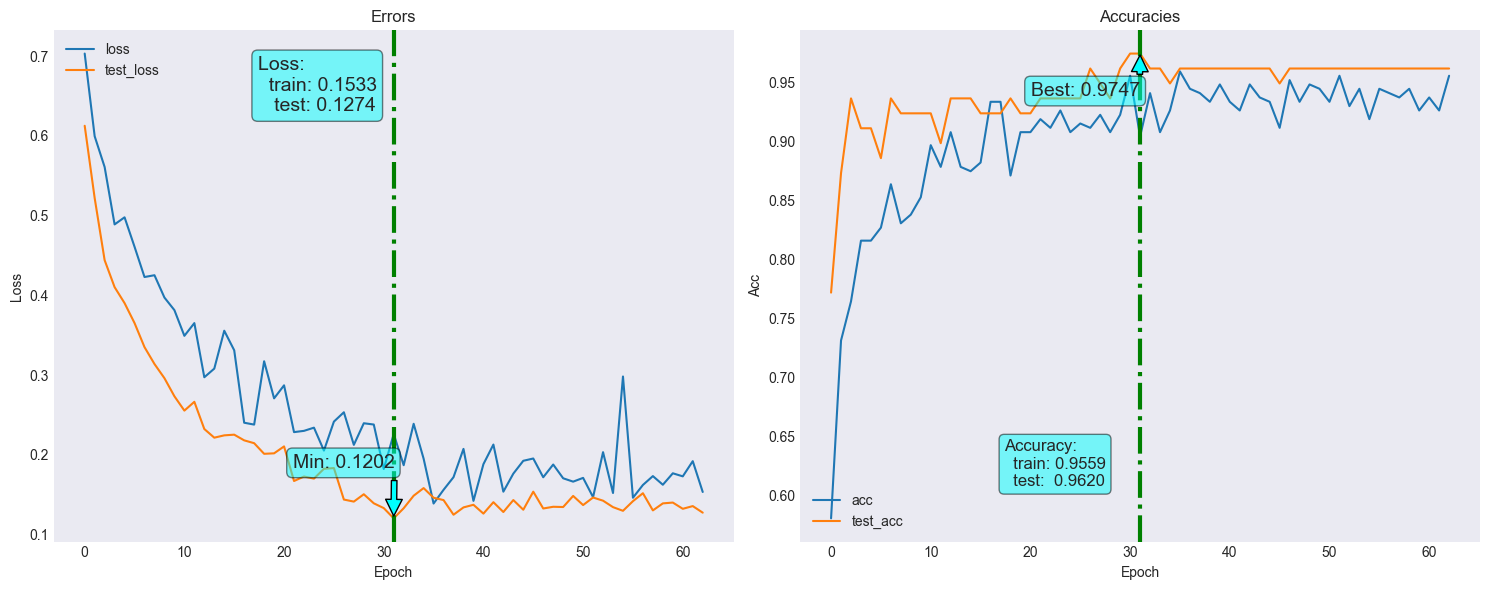

In [16]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})
fn_plot_torch_hist(loss_df)

## Training Confusion matrics

In [17]:
y_train = []
y_pred = []

for i, (data,target) in enumerate (train_loader):
    outputs = model(data)
    pred = torch.argmax(outputs, dim=1)
    y_train.extend(target.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

In [18]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        98
           1       0.98      0.99      0.99       174

    accuracy                           0.98       272
   macro avg       0.98      0.98      0.98       272
weighted avg       0.98      0.98      0.98       272



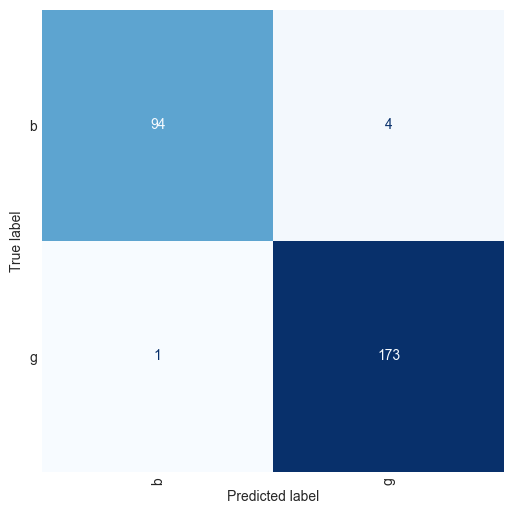

In [19]:
class_labels = {k : v for k,v in enumerate(train_ds.transformers.encoder.classes_)}
fn_plot_confusion_matrix(y_train,y_pred,class_labels)

## Testing Confusion matrics

In [20]:
y_test = []
y_pred = []

for i, (data,target) in enumerate (test_loader):
    outputs = model(data)
    pred = torch.argmax(outputs, dim=1)
    y_test.extend(target.numpy())
    y_pred.extend(pred.numpy())

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.94      1.00      0.97        51

    accuracy                           0.96        79
   macro avg       0.97      0.95      0.96        79
weighted avg       0.96      0.96      0.96        79



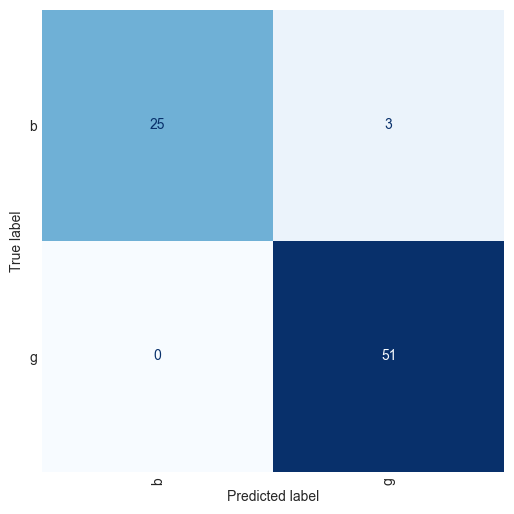

In [22]:
class_labels = {k : v for k,v in enumerate(test_ds.transformers.encoder.classes_)}
fn_plot_confusion_matrix(y_test,y_pred,class_labels)